#  Implement BNN

## Experiments

The experiments are as follows:

Experiment 0: A non-stochastic, non-binary baseline.

Experiment 1: A stochastic, binary result.  

## Imports and Utility functions

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
from tensorflow.python.framework import ops
from enum import Enum
import seaborn as sns
sns.set(color_codes=True)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def layer_linear(inputs, shape, scope='linear_layer'):
    with tf.variable_scope(scope):
        w = tf.get_variable('w',shape)
        b = tf.get_variable('b',shape[-1:])
    return tf.matmul(inputs,w) + b

def layer_softmax(inputs, shape, scope='softmax_layer'):
    with tf.variable_scope(scope):
        w = tf.get_variable('w',shape)
        b = tf.get_variable('b',shape[-1:])
    return tf.nn.softmax(tf.matmul(inputs,w) + b)

def accuracy(y, pred):
    correct = tf.equal(tf.argmax(y,1), tf.argmax(pred,1))
    return tf.reduce_mean(tf.cast(correct, tf.float32))

def plot_n(data_and_labels, lower_y = 0., title="Learning Curves"):
    fig, ax = plt.subplots()
    for data, label in data_and_labels:
        ax.plot(range(0,len(data)*100,100),data, label=label)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([lower_y,1])
    ax.set_title(title)
    ax.legend(loc=4)
    plt.show()

class StochasticGradientEstimator(Enum):
    ST = 0
    REINFORCE = 1

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Binary stochastic neuron with stright through estimator

In [2]:
def binaryRound(x):
    """
    Rounds a tensor whose values are in [0,1] to a tensor with values in {0, 1},
    using the straight through estimator for the gradient.
    """
    g = tf.get_default_graph()

    with ops.name_scope("BinaryRound") as name:
        with g.gradient_override_map({"Round": "Identity"}):
            return tf.round(x, name=name)

In [3]:
def bernoulliSample(x):
    """
    Uses a tensor whose values are in [0,1] to sample a tensor with values in {0, 1},
    using the straight through estimator for the gradient.

    E.g.,:
    if x is 0.6, bernoulliSample(x) will be 1 with probability 0.6, and 0 otherwise,
    and the gradient will be pass-through (identity).
    """
    g = tf.get_default_graph()

    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]

In [4]:
def passThroughSigmoid(x, slope=1):
    """Sigmoid that uses identity function as its gradient"""
    g = tf.get_default_graph()
    with ops.name_scope("PassThroughSigmoid") as name:
        with g.gradient_override_map({"Sigmoid": "Identity"}):
            return tf.sigmoid(x, name=name)

def binaryStochastic_ST(x, slope_tensor=None, pass_through=True, stochastic=True):
    """
    Sigmoid followed by either a random sample from a bernoulli distribution according
    to the result (binary stochastic neuron) (default), or a sigmoid followed by a binary
    step function (if stochastic == False). Uses the straight through estimator.
    See https://arxiv.org/abs/1308.3432.

    Arguments:
    * x: the pre-activation / logit tensor
    * slope_tensor: if passThrough==False, slope adjusts the slope of the sigmoid function
        for purposes of the Slope Annealing Trick (see http://arxiv.org/abs/1609.01704)
    * pass_through: if True (default), gradient of the entire function is 1 or 0;
        if False, gradient of 1 is scaled by the gradient of the sigmoid (required if
        Slope Annealing Trick is used)
    * stochastic: binary stochastic neuron if True (default), or step function if False
    """
    if slope_tensor is None:
        slope_tensor = tf.constant(1.0)

    if pass_through:
        p = passThroughSigmoid(x)
    else:
        p = tf.sigmoid(slope_tensor*x)

    if stochastic:
        return bernoulliSample(p)
    else:
        return binaryRound(p)

## Wrapper to create layer of binary stochastic neurons

In [9]:
def binary_wrapper(\
                pre_activations_tensor,
                estimator=StochasticGradientEstimator.ST,
                stochastic_tensor=tf.constant(True),
                pass_through=True,
                slope_tensor=tf.constant(1.0)):
    """
    Turns a layer of pre-activations (logits) into a layer of binary stochastic neurons

    Keyword arguments:
    *estimator: either ST or REINFORCE
    *stochastic_tensor: a boolean tensor indicating whether to sample from a bernoulli
        distribution (True, default) or use a step_function (e.g., for inference)
    *pass_through: for ST only - boolean as to whether to substitute identity derivative on the
        backprop (True, default), or whether to use the derivative of the sigmoid
    *slope_tensor: for ST only - tensor specifying the slope for purposes of slope annealing
        trick
    """

    if estimator == StochasticGradientEstimator.ST:
        if pass_through:
            return tf.cond(stochastic_tensor,
                    lambda: binaryStochastic_ST(pre_activations_tensor),
                    lambda: binaryStochastic_ST(pre_activations_tensor, stochastic=False))
        else:
            return tf.cond(stochastic_tensor,
                    lambda: binaryStochastic_ST(pre_activations_tensor, slope_tensor = slope_tensor,
                                             pass_through=False),
                    lambda: binaryStochastic_ST(pre_activations_tensor, slope_tensor = slope_tensor,
                                             pass_through=False, stochastic=False))
    elif estimator == StochasticGradientEstimator.REINFORCE:
        # binaryStochastic_REINFORCE was designed to only be stochastic, so using the ST version
        # for the step fn for purposes of using step fn at evaluation / not for training
        return tf.cond(stochastic_tensor,
                lambda: binaryStochastic_REINFORCE(pre_activations_tensor),
                lambda: binaryStochastic_ST(pre_activations_tensor, stochastic=False))

    else:
        raise ValueError("Unrecognized estimator.")

## Function to build graph for MNIST classifier

In [5]:
def build_classifier(hidden_dims=[100],
                        lr = 0.5,
                        pass_through = True,
                        non_binary = False,
                        estimator = StochasticGradientEstimator.ST,
                        no_var_adj=False):
    reset_graph() 
    g = {}

    if no_var_adj:
        tf.get_default_graph().add_to_collection("REINFORCE", {"no_variance_adj": no_var_adj})

    g['x'] = tf.placeholder(tf.float32, [None, 784], name='x_placeholder')
    g['y'] = tf.placeholder(tf.float32, [None, 10], name='y_placeholder')
    g['stochastic'] = tf.constant(True)
    g['slope'] = tf.constant(1.0)

    g['layers'] = {0: g['x']}
    hidden_layers = len(hidden_dims)
    dims = [784] + hidden_dims

    for i in range(1, hidden_layers+1):
        with tf.variable_scope("layer_" + str(i)):
            pre_activations = layer_linear(g['layers'][i-1], dims[i-1:i+1], scope='layer_' + str(i))
            if non_binary:
                g['layers'][i] = tf.sigmoid(pre_activations)
            else:
                g['layers'][i] = binary_wrapper(pre_activations,
                                              estimator = estimator,
                                              pass_through = pass_through,
                                              stochastic_tensor = g['stochastic'],
                                              slope_tensor = g['slope'])

    g['pred'] = layer_softmax(g['layers'][hidden_layers], [dims[-1], 10])

    g['loss'] = -tf.reduce_mean(g['y'] * tf.log(g['pred']),reduction_indices=1)

    # named loss_by_example necessary for REINFORCE estimator
    tf.identity(g['loss'], name="loss_by_example")

    g['ts'] = tf.train.GradientDescentOptimizer(lr).minimize(g['loss'])

    g['accuracy'] = accuracy(g['y'], g['pred'])

    g['init_op'] = tf.global_variables_initializer()
    return g

## Function to train classifier

In [6]:
def train_classifier(\
        hidden_dims=[100,100],
        estimator=StochasticGradientEstimator.ST,
        stochastic_train=True,
        stochastic_eval=True,
        slope_annealing_rate=None,
        epochs=10,
        lr=0.5,
        non_binary=False,
        no_var_adj=False,
        train_set = mnist.train,
        val_set = mnist.validation,
        verbose=False,
        label=None):
    if slope_annealing_rate is None:
        g = build_classifier(hidden_dims=hidden_dims, lr=lr, pass_through=True,
                                non_binary=non_binary, estimator=estimator, no_var_adj=no_var_adj)
    else:
        g = build_classifier(hidden_dims=hidden_dims, lr=lr, pass_through=False,
                                non_binary=non_binary, estimator=estimator, no_var_adj=no_var_adj)

    with tf.Session() as sess:
        sess.run(g['init_op'])
        slope = 1
        res_tr, res_val = [], []
        for epoch in range(epochs):
            feed_dict={g['x']: val_set.images,
                       g['y']: val_set.labels,
                       g['stochastic']: stochastic_eval,
                       g['slope']: slope}
            if verbose:
                print("Epoch", epoch, sess.run(g['accuracy'], feed_dict=feed_dict))

            accuracy = 0
            for i in range(1001):
                x, y = train_set.next_batch(50)
                feed_dict={g['x']: x, g['y']: y, g['stochastic']: stochastic_train}
                acc, _ = sess.run([g['accuracy'],g['ts']], feed_dict=feed_dict)
                accuracy += acc
                if i % 100 == 0 and i > 0:
                    res_tr.append(accuracy/100)
                    accuracy = 0
                    feed_dict={g['x']: val_set.images,
                               g['y']: val_set.labels,
                               g['stochastic']: stochastic_eval,
                               g['slope']: slope}
                    res_val.append(sess.run(g['accuracy'], feed_dict=feed_dict))

            if slope_annealing_rate is not None:
                slope = slope*slope_annealing_rate
                if verbose:
                    print("Sigmoid slope:", slope)

        feed_dict={g['x']: val_set.images, g['y']: val_set.labels,
                   g['stochastic']: stochastic_eval, g['slope']: slope}
        print("Epoch", epoch+1, sess.run(g['accuracy'], feed_dict=feed_dict))
        if label is not None:
            return (res_tr, label + " - Training"), (res_val, label + " - Validation")
        else:
            return [(res_tr, "Training"), (res_val, "Validation")]

# Experiment 0: A non-stochastic, non-binary baseline.

('Epoch', 20, 0.95519972)


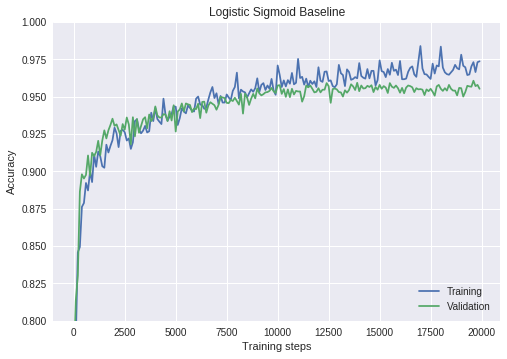

In [7]:
res = train_classifier(hidden_dims=[100], epochs=20, lr=1.0, non_binary=True)
plot_n(res, lower_y=0.8, title="Logistic Sigmoid Baseline")

## Experiment 1: A stochastic, binary result.

('Epoch', 20, 0.84999979)


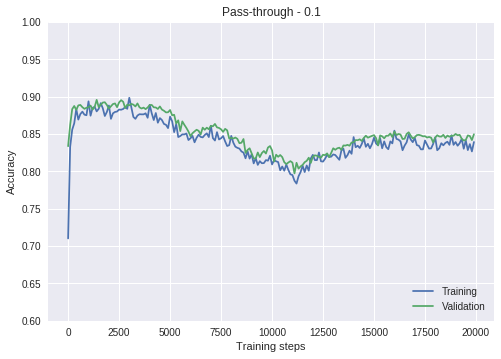

In [18]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, lr=0.1)
plot_n(res1, lower_y=0.6, title="Pass-through - 0.1")